In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Friendly class names
CLASS_NAME = {
    0: "Brushing Hair (E1)",
    1: "Brushing Teeth (E2)",
    2: "Hip Flexion (E5)",
}

left_arm = [13, 15, 17, 19, 21] 
right_arm = [14, 16, 18, 20, 22] 
left_points = [11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31] 
right_points = [12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32] 

In [3]:
# Load data
X1 = pd.read_pickle("Xtrain1.pkl")
y = np.load("Ytrain1.npy")

# Extract features
# 700 sequences x (33 keypoints x mean of 2 dimensions + 33 keypoints x std of 2 dimensions) 
# [Kp0x_mean, Kp0y_mean,....,Kp32x_mean,Kp32y_mean,Kp0x_std,Kp0y_std,...,Kp32x_std,Kp32y_std]
X = np.stack(X1["Skeleton_Features"]) # (700, 132)

Class imbalance (F1-score use justification)

In [4]:
unique, counts = np.unique(y, return_counts=True)

for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples")

Class 0.0: 280 samples
Class 1.0: 280 samples
Class 2.0: 140 samples


Normalization: center by torso centroid, scale horizontally (shoulders) and vertically (head-hip)

In [5]:
# Normalization: center by torso centroid, scale horizontally (shoulders) and vertically (head-hip)

# Split into means and stds
means = X[:, :66].reshape(-1, 33, 2)
stds  = X[:, 66:].reshape(-1, 33, 2)

# Keypoint indices
shoulders = [11, 12]
hips = [23, 24]
head = 0
torso_indices = shoulders + hips

# Compute torso centroid, shoulder distance, and vertical distance (per sample)
centroid = means[:, torso_indices].mean(axis=1)  # (n_samples, 2)
shoulder_dist = np.linalg.norm(means[:, shoulders[0]] - means[:, shoulders[1]], axis=1)
mid_hip = means[:, hips].mean(axis=1)
vert_dist = np.linalg.norm(means[:, head] - mid_hip, axis=1)

# Avoid divide-by-zero
shoulder_dist[shoulder_dist == 0] = 1
vert_dist[vert_dist == 0] = 1

# Normalize means (center + scale)
means_centered = means - centroid[:, None, :]
means_norm = np.empty_like(means_centered)
means_norm[:, :, 0] = means_centered[:, :, 0] / shoulder_dist[:, None]
means_norm[:, :, 1] = means_centered[:, :, 1] / vert_dist[:, None]

# Normalize stds (scale only)
stds_norm = np.empty_like(stds)
stds_norm[:, :, 0] = stds[:, :, 0] / shoulder_dist[:, None]
stds_norm[:, :, 1] = stds[:, :, 1] / vert_dist[:, None]

# Concatenate back into (n_samples, 132)
X_norm = np.concatenate([means_norm.reshape(len(X), -1),
                         stds_norm.reshape(len(X), -1)], axis=1)

Side of exercise imbalance

In [6]:
def detect_mov_side(X_sample):

    stds = X_sample[66:].reshape(33, 2)
    left_std_sum = np.sum(stds[left_arm])
    right_std_sum = np.sum(stds[right_arm])

    if left_std_sum >= right_std_sum:
        return 'left'
    else:
        return 'right'

left_counts = np.zeros(len(CLASS_NAME), dtype=int)
right_counts = np.zeros(len(CLASS_NAME), dtype=int)

for row_idx in X1.index:
    if detect_mov_side(X_norm[row_idx]) == 'left':
        left_counts[int(y[row_idx])] += 1
    else:
        right_counts[int(y[row_idx])] += 1

print("Left side movement counts per class:", left_counts)
print("Right side movement counts per class:", right_counts)


Left side movement counts per class: [179 175  62]
Right side movement counts per class: [101 105  78]


Mirror left points to the right over central axis, and keep only the arm with most movement

In [7]:
def active_arm(X):
    n_samples = X.shape[0]
    X_out = []
    for i in range(n_samples):
        feats = X[i].copy()
        means = feats[:66].reshape(33, 2)
        stds  = feats[66:].reshape(33, 2)

        # Shoulders for vertical axis (x = axis_x)
        L = means[11]
        R = means[12]
        axis_x = (L[0] + R[0]) / 2

        # which arm is active?
        side = detect_mov_side(feats)

        if side == "right":
            # Just keep right arm, remove left arm
            keep_idxs = [k for k in range(33) if k not in left_arm]
            means = means[keep_idxs]
            stds  = stds[keep_idxs]
        else:
            # Mirror the whole skeleton over vertical axis, keep right arm (mirrored left), remove original right arm
            means_mir = means.copy()
            stds_mir = stds.copy()
            # Mirror all points
            means_mir[:, 0] = 2 * axis_x - means[:, 0]
            # Copy left arm to right arm indices
            #for l, r in zip(left_arm, right_arm):
            #    means_mir[r] = means_mir[l]
            #    stds_mir[r] = stds_mir[l]
            # Remove left arm (now at right_points), keep all except left_points
            keep_idxs = [k for k in range(33) if k not in right_arm]
            means = means_mir[keep_idxs]
            stds  = stds_mir[keep_idxs]

        # flatten back to [means + stds]
        X_out.append(np.concatenate([means.flatten(), stds.flatten()]))

    X_out = np.vstack(X_out)
    return X_out

# Apply to all samples
X_active = active_arm(X_norm)

print(X_active.shape)


(700, 112)


Standardize

In [8]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X_norm)

PCA

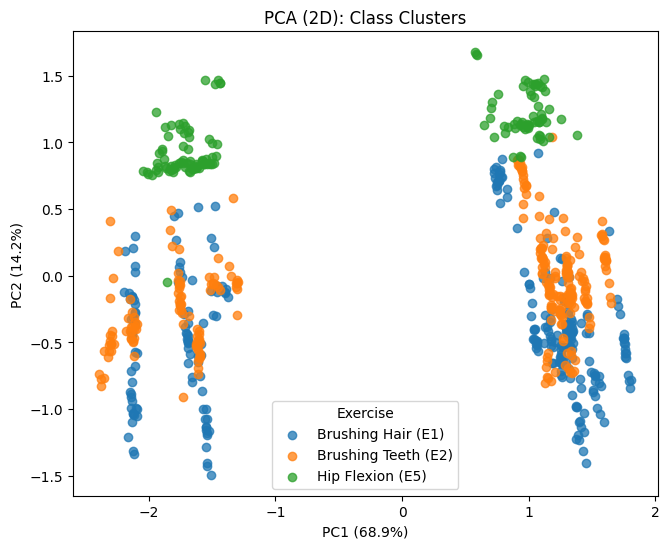

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_active)
evr = pca.explained_variance_ratio_ * 100

plt.figure(figsize=(6.8, 5.6))
for cls in [0, 1, 2]:
    pts = X_pca[y == cls]
    plt.scatter(pts[:, 0], pts[:, 1], alpha=0.75, label=CLASS_NAME[cls])
plt.xlabel(f"PC1 ({evr[0]:.1f}%)")
plt.ylabel(f"PC2 ({evr[1]:.1f}%)")
plt.title("PCA (2D): Class Clusters")
plt.legend(title="Exercise")
plt.tight_layout()
plt.show()

## Visualize Mean and Std of Each Keypoint in XY for a Single Exercise and Patient (with Labels and Body Part Colors)

This cell plots the mean position (x, y) of each keypoint for a single exercise and patient, with error bars representing the standard deviation. Each point is labeled with its keypoint index and colored by body part: head, right arm, left arm, left leg, right leg.

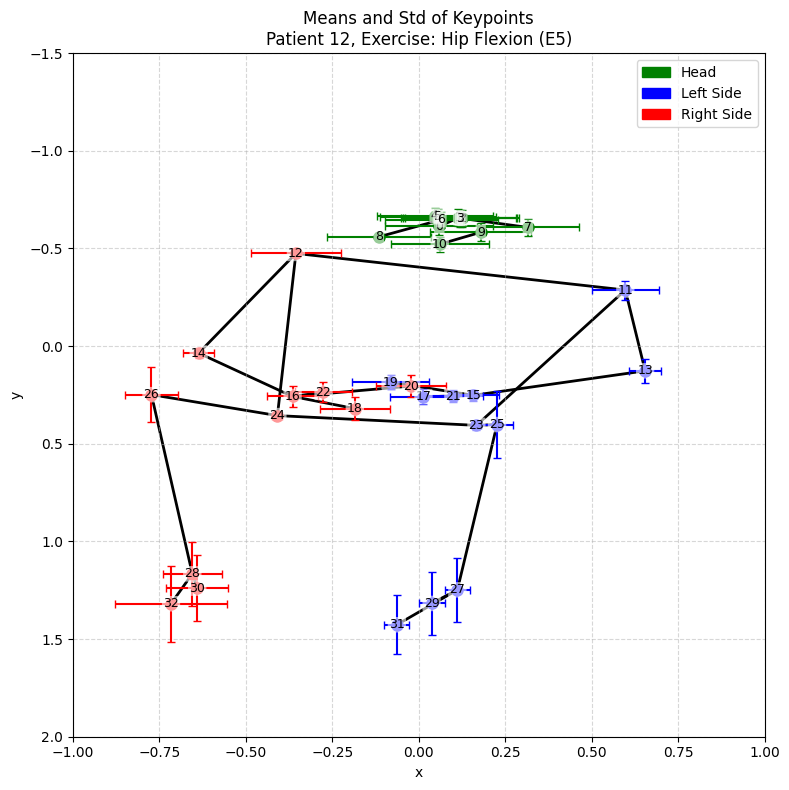

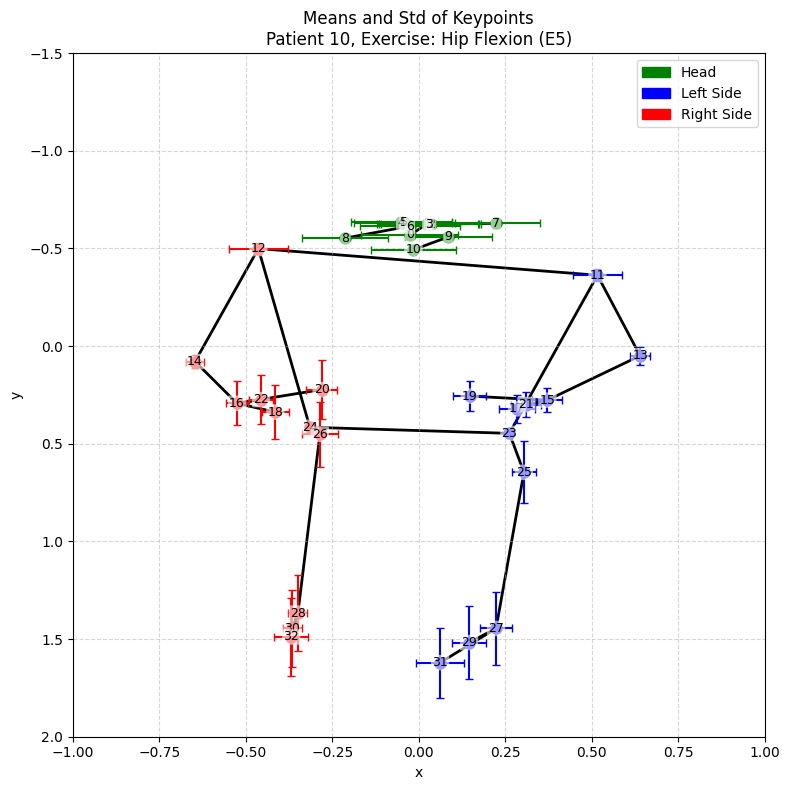

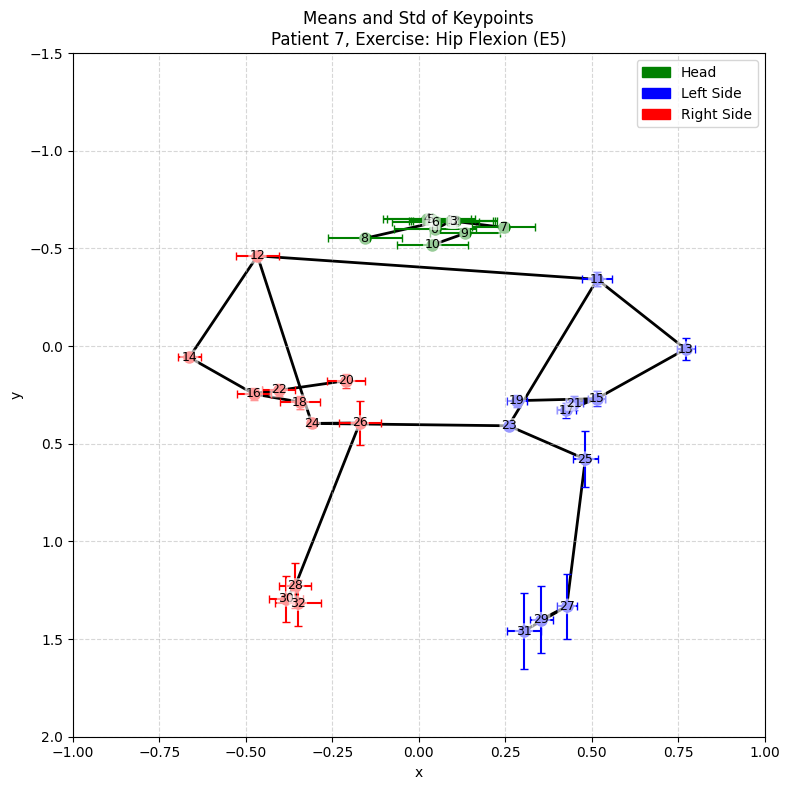

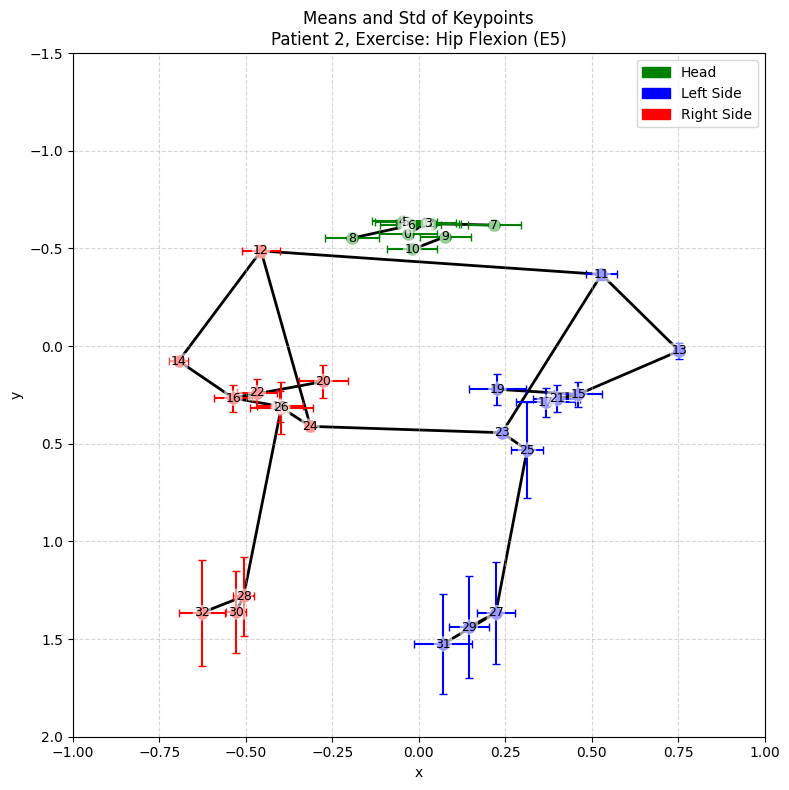

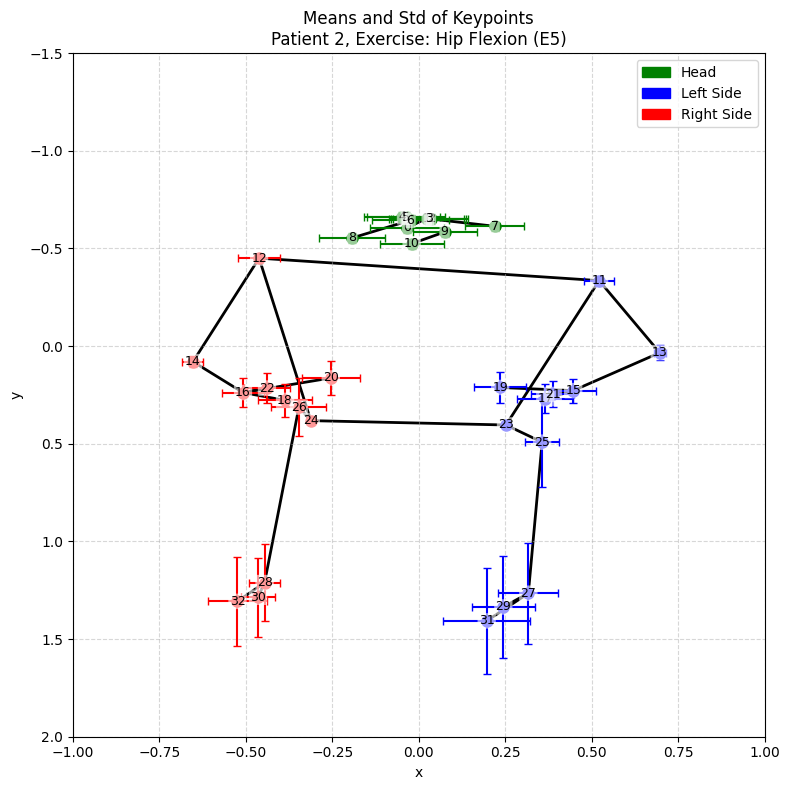

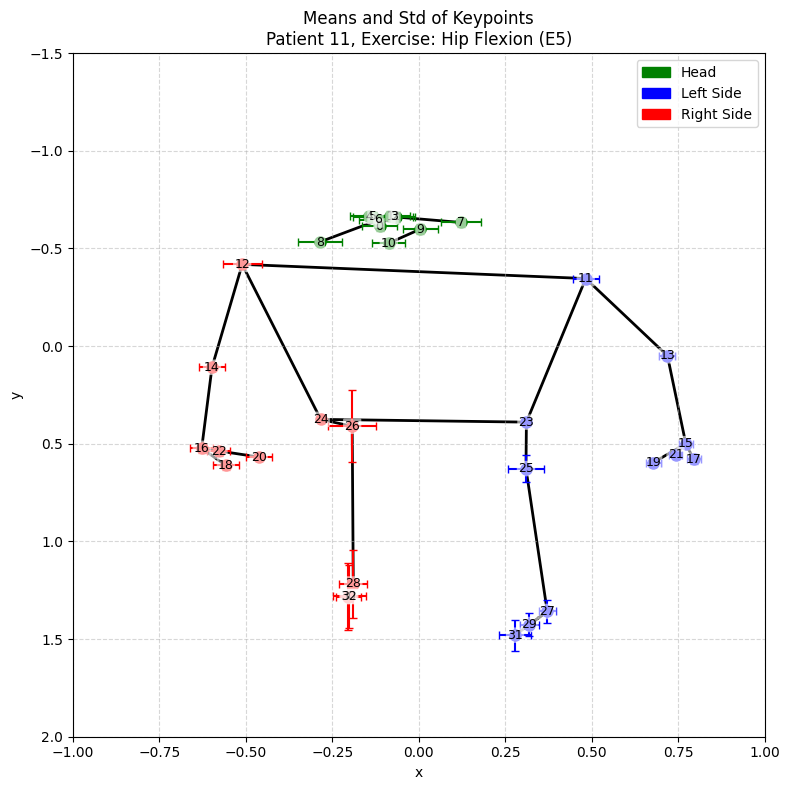

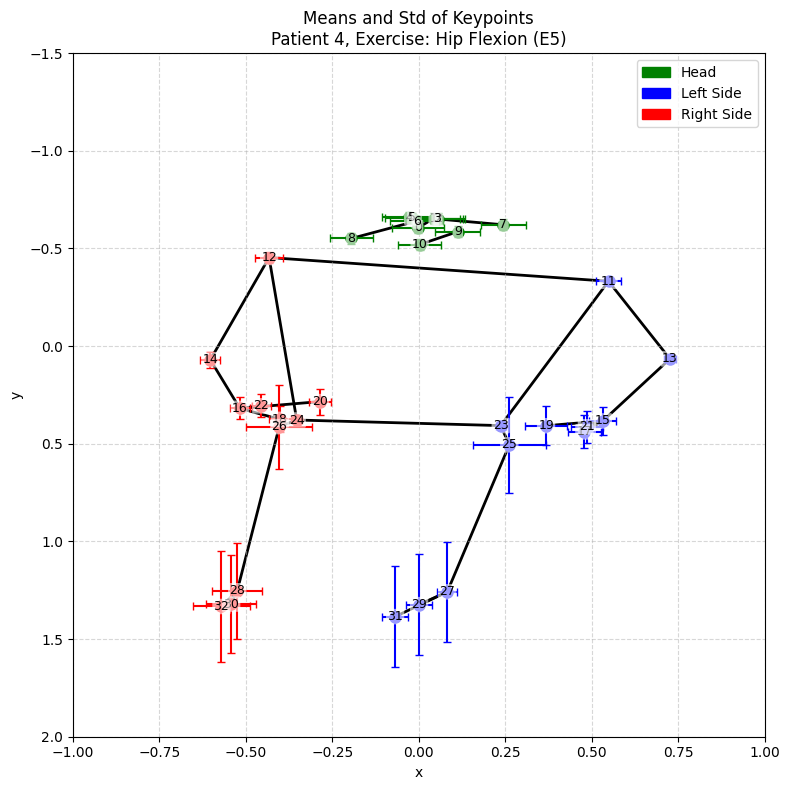

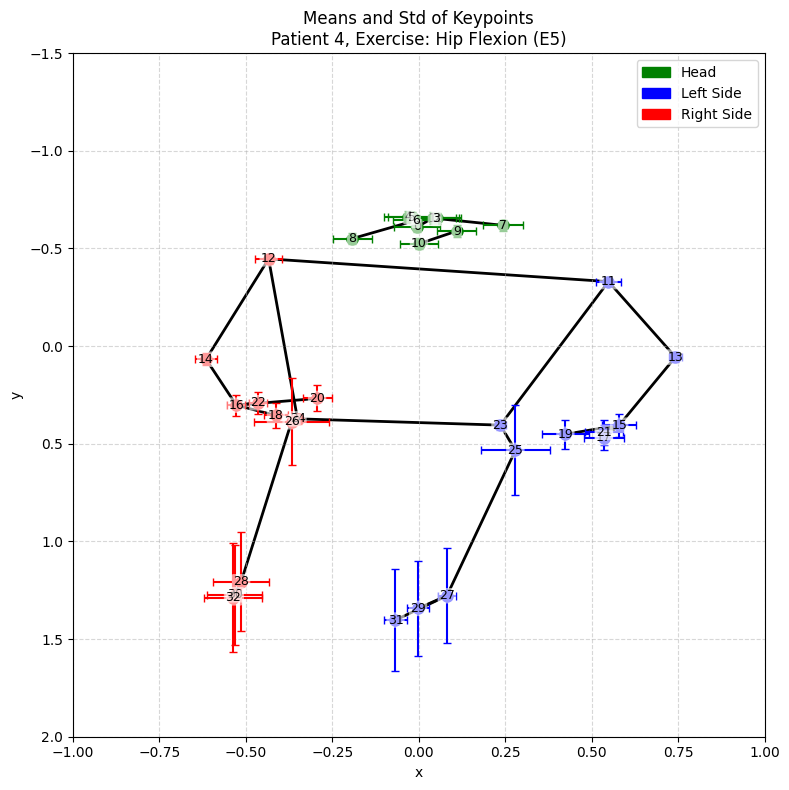

In [18]:
# Divide body in 4 colored parts
bodypart_colors = np.array(
    ['green'] * 11 +  # 0-10: head
    ['blue', 'red', 'blue', 'red', 'blue', 'red'] +  # 11-16: arms
    ['blue', 'red', 'blue', 'red', 'blue', 'red'] +  # 17-22: hands
    ['blue', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'red']  # 23-32: legs
)

#loop
CLASS = 2
INDEX_LIMIT = 50
for row_idx in [i for i in X1.index if y[i] == CLASS and i < INDEX_LIMIT]:
    patient_id = X1.iloc[row_idx]['Patient_Id']
    exercise_label = y[row_idx]
    exercise_name = CLASS_NAME[exercise_label]

    # Extract means and stds for all 33 keypoints (x, y for each)
    features = X_norm[row_idx]
    means = features[:66].reshape(33, 2)  # shape (33, 2)
    stds = features[66:].reshape(33, 2)   # shape (33, 2)

    plt.figure(figsize=(8, 8))
    for i in range(33):
        plt.errorbar(means[i, 0], means[i, 1], xerr=stds[i, 0], yerr=stds[i, 1], fmt='o',
                    color=bodypart_colors[i], ecolor=bodypart_colors[i], capsize=3, markersize=8)
        plt.text(means[i, 0], means[i, 1], str(i), fontsize=9, ha='center', va='center',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, boxstyle='round,pad=0.1'))

    # Custom legend for body parts
    import matplotlib.patches as mpatches
    legend_patches = [
        mpatches.Patch(color='green', label='Head'),
        mpatches.Patch(color='blue', label='Left Side'),
        mpatches.Patch(color='red', label='Right Side'),
    ]
    plt.legend(handles=legend_patches, loc='upper right')

    # Define skeleton edges (from your skeleton.png)
    skeleton_edges = [
        (0,1),(1,2),(2,3),(3,7),(0,4),(4,5),(5,6),(6,8),(9,10),
        (11,12),(11,23),(12,24),(23,24),
        (11,13),(13,15),(15,17),(15,19),(15,21),
        (12,14),(14,16),(16,18),(16,20),(16,22),
        (23,25),(25,27),(27,29),(27,31),
        (24,26),(26,28),(28,30),(28,32)
    ]
    # Draw skeleton lines in black
    for (i, j) in skeleton_edges:
        plt.plot([means[i,0], means[j,0]], [means[i,1], means[j,1]], 'k-', linewidth=2, zorder=1)

    plt.title(f'Means and Std of Keypoints\nPatient {patient_id}, Exercise: {exercise_name}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-1, 1])
    plt.ylim([-1.5, 2])
    plt.gca().invert_yaxis()  # Invert y for image coordinates
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

(112,)


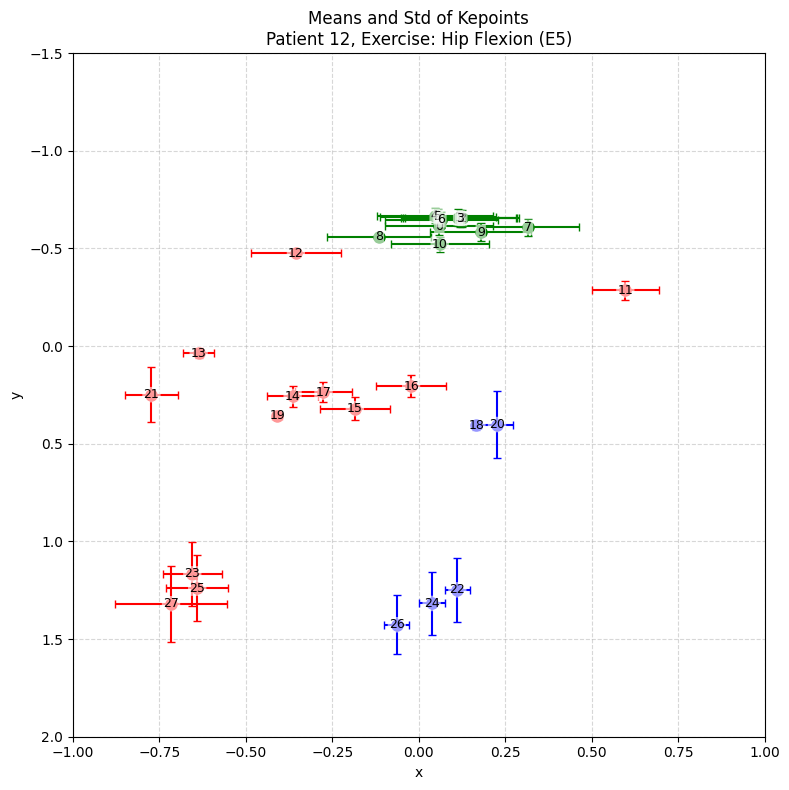

(112,)


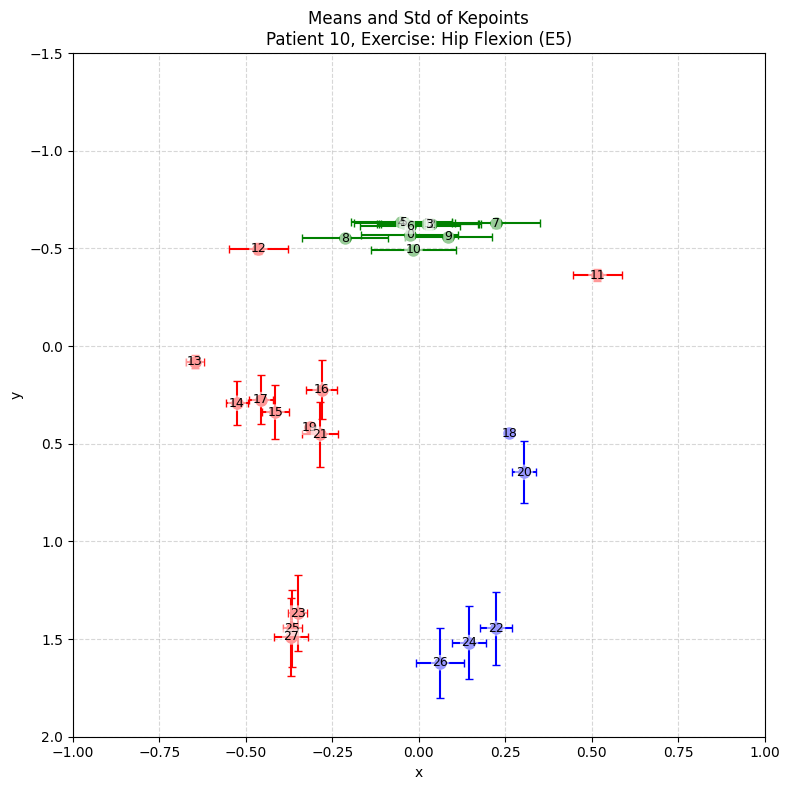

(112,)


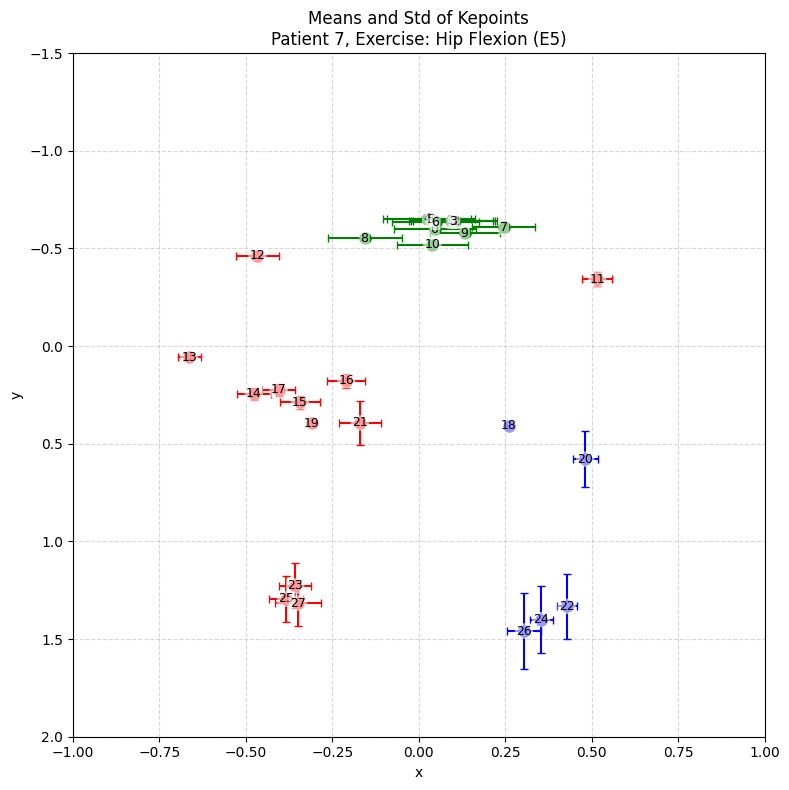

(112,)


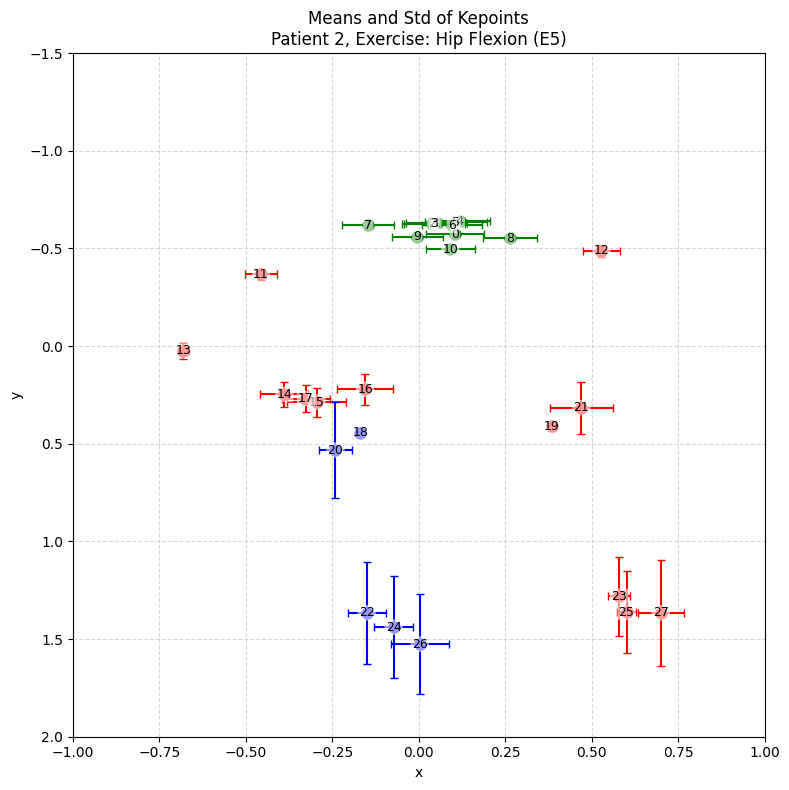

(112,)


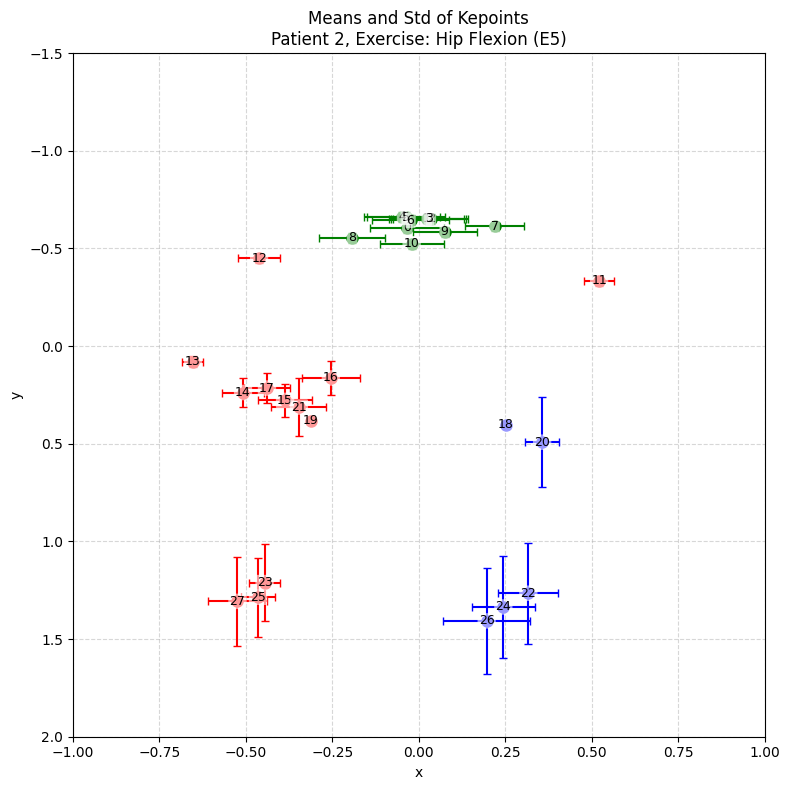

(112,)


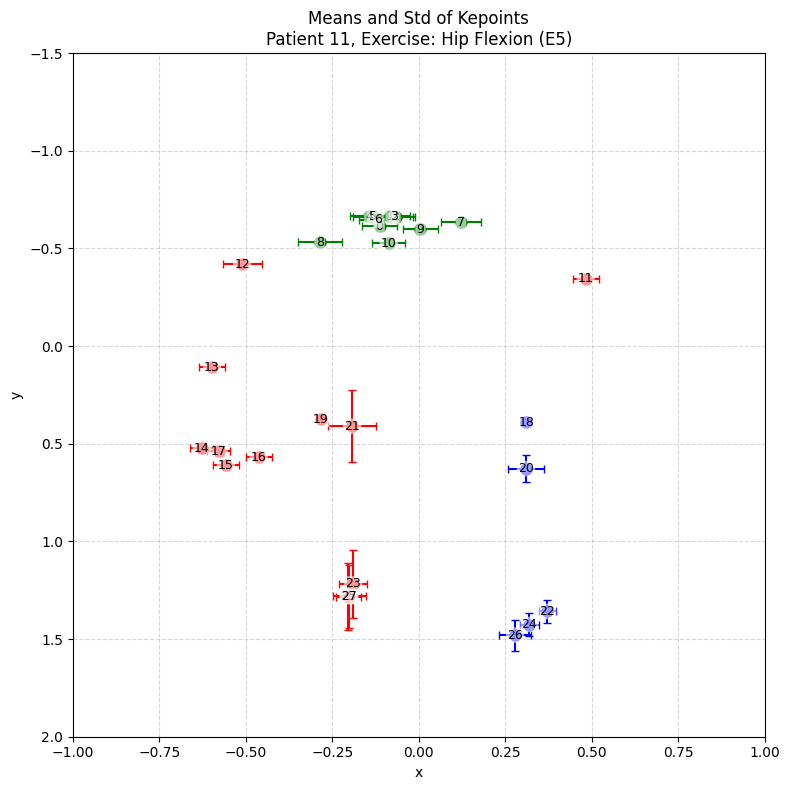

(112,)


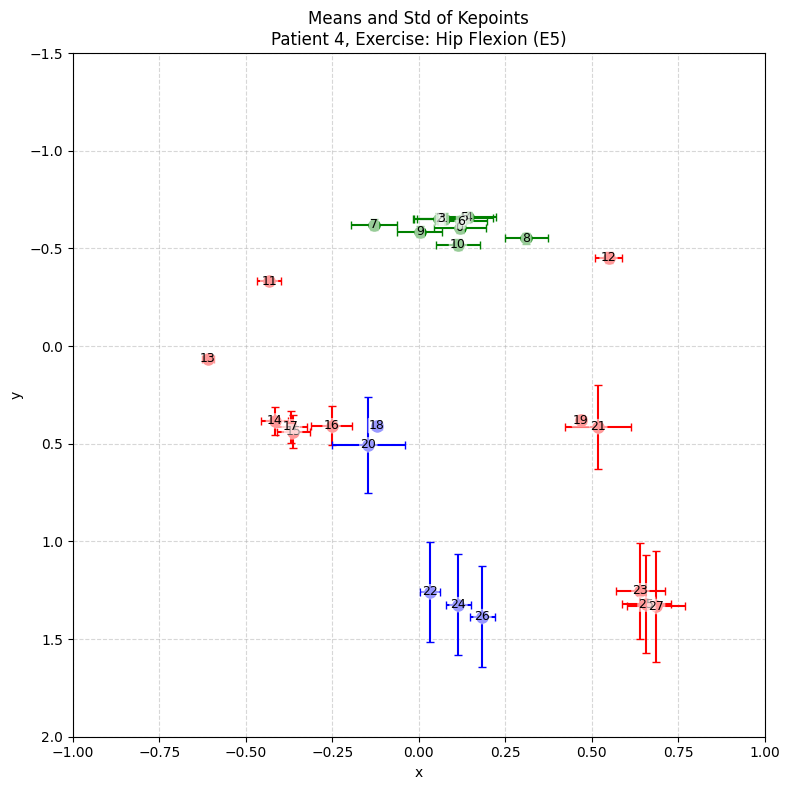

(112,)


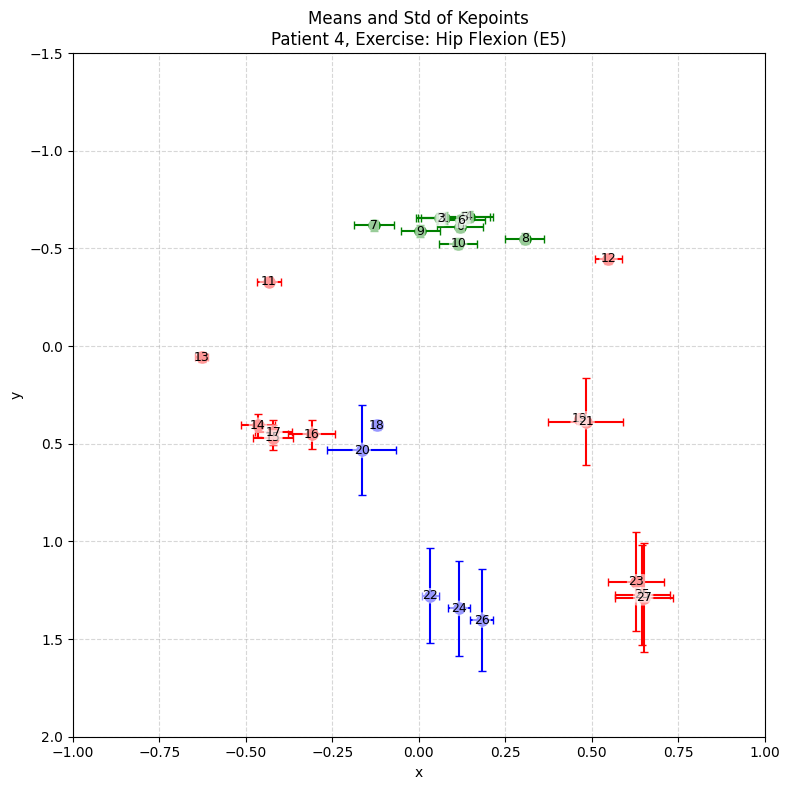

In [ ]:
# Divide body in 4 colored parts
bodypart_colors = np.array(
    ['green'] * 11 +  # 0-10: head
    ['red', 'red', 'red', 'red', 'red', 'red', 'red'] +  # 17-22: hands
    ['blue', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'red']  # 23-32: legs
)

#loop
CLASS = 2
INDEX_LIMIT = 50
for row_idx in [i for i in X1.index if y[i] == CLASS and i < INDEX_LIMIT]:
    patient_id = X1.iloc[row_idx]['Patient_Id']
    exercise_label = y[row_idx]
    exercise_name = CLASS_NAME[exercise_label]

    # Extract means and stds for all 33 keypoints (x, y for each)
    features = X_active[row_idx]
    print( features.shape )
    means = features[:56].reshape(28, 2)  # shape (33, 2)
    stds = features[56:].reshape(28, 2)   # shape (33, 2)

    plt.figure(figsize=(8, 8))
    for i in range(28):
        plt.errorbar(means[i, 0], means[i, 1], xerr=stds[i, 0], yerr=stds[i, 1], fmt='o',
                    color=bodypart_colors[i], ecolor=bodypart_colors[i], capsize=3, markersize=8)
        plt.text(means[i, 0], means[i, 1], str(i), fontsize=9, ha='center', va='center',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, boxstyle='round,pad=0.1'))

    plt.title(f'Means and Std of Kepoints\nPatient {patient_id}, Exercise: {exercise_name}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-1, 1])
    plt.ylim([-1.5, 2])
    plt.gca().invert_yaxis()  # Invert y for image coordinates
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()